#### Import Necessary Libraries

In [1]:
import random
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

#### Generate Random Data

In [2]:
# List of cities
cities = ["Mumbai", "Delhi", "Bengaluru", "Chennai"]

random.seed(42)

# Generate random data
data = []
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 6, 30)

for _ in range(50000):
    customer_id = random.randint(1000, 9999)
    order_id = random.randint(10000, 99999)
    city = random.choice(cities)
    purchase_date = start_date + timedelta(days=random.randint(0, (end_date - start_date).days))
    transaction_amount = round(random.uniform(15, 1500), 2)
    
    data.append({
        "Customer_ID": customer_id,
        "Order_ID": order_id,
        "City": city,
        "Purchase_Date": purchase_date.strftime("%Y-%m-%d"),
        "Transaction_Amount": transaction_amount
    })
    
df = pd.DataFrame(data)

#### Exploring Data

In [3]:
print(df.head())
print("****************************************************************************************")
print(df.tail())

   Customer_ID  Order_ID       City Purchase_Date  Transaction_Amount
0         2824     13278  Bengaluru    2023-03-04              346.47
1         2679     98696     Mumbai    2023-06-01              641.55
2         1488     22280      Delhi    2023-03-01              765.45
3         1434     83563      Delhi    2023-06-16             1056.47
4         7873     38893    Chennai    2023-05-31              428.11
****************************************************************************************
       Customer_ID  Order_ID       City Purchase_Date  Transaction_Amount
49995         5472     27925    Chennai    2023-04-05             1003.41
49996         3543     99277      Delhi    2023-06-12              666.80
49997         7800     52170  Bengaluru    2023-05-13              213.90
49998         7203     91592     Mumbai    2023-05-08              615.87
49999         9737     39873    Chennai    2023-02-07              709.14


In [4]:
print(df.shape)
print("****************************************************************************************")
print(df[df.duplicated()])
print("****************************************************************************************")
print(df.info())

(50000, 5)
****************************************************************************************
Empty DataFrame
Columns: [Customer_ID, Order_ID, City, Purchase_Date, Transaction_Amount]
Index: []
****************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         50000 non-null  int64  
 1   Order_ID            50000 non-null  int64  
 2   City                50000 non-null  object 
 3   Purchase_Date       50000 non-null  object 
 4   Transaction_Amount  50000 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 1.9+ MB
None


#### We identified there are no duplicates, no null values in the data

In [5]:
# Change datatype of PurchseDate column
df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'])

In [6]:
# Calculate individual recency, frequency & monetary value
current_date = datetime.now()
df['Recency'] = (current_date - df['Purchase_Date']).dt.days

df['Frequency'] = df.groupby("Customer_ID")['Order_ID'].transform("count")

df['Monetary_Value'] = df.groupby("Customer_ID")['Transaction_Amount'].transform("sum")

In [7]:
df.head(2)

,Customer_ID,Order_ID,City,Purchase_Date,Transaction_Amount,Recency,Frequency,Monetary_Value
0,2824,13278,Bengaluru,2023-03-04,346.47,166,4,2021.11
1,2679,98696,Mumbai,2023-06-01,641.55,77,6,3979.84


In [8]:
# Calculate Recency Score, Frequency Score, Monetary Score

df['Recency_Score'] = pd.cut(df['Recency'], bins= 5, labels= [5,4,3,2,1])
df['Frequency_Score'] = pd.cut(df['Frequency'], bins= 5, labels= [1,2,3,4,5])
df['Monetary_Score'] = pd.cut(df['Monetary_Value'], bins= 5, labels= [1,2,3,4,5])

# Converting scores to int datatype
df[['Recency_Score', 'Frequency_Score', 'Monetary_Score']] = df[['Recency_Score', 'Frequency_Score', 'Monetary_Score']].astype(int)

### Individual R,F,M Scores
+ Most recent orders purchases gets the highest score and vice-versa
+ More frequent orders gets the highest score and vice-versa
+ Highest order value gets the highest score and vice-versa

In [9]:
df.head(2)

,Customer_ID,Order_ID,City,Purchase_Date,Transaction_Amount,Recency,Frequency,Monetary_Value,Recency_Score,Frequency_Score,Monetary_Score
0,2824,13278,Bengaluru,2023-03-04,346.47,166,4,2021.11,2,1,1
1,2679,98696,Mumbai,2023-06-01,641.55,77,6,3979.84,5,2,2


### Calculating RFM Score
+ RFM Score is calculated by summing recency score, frequency score and monetary score

In [10]:
df['RFM_Score'] = df['Recency_Score'] + df['Frequency_Score'] + df['Monetary_Score']

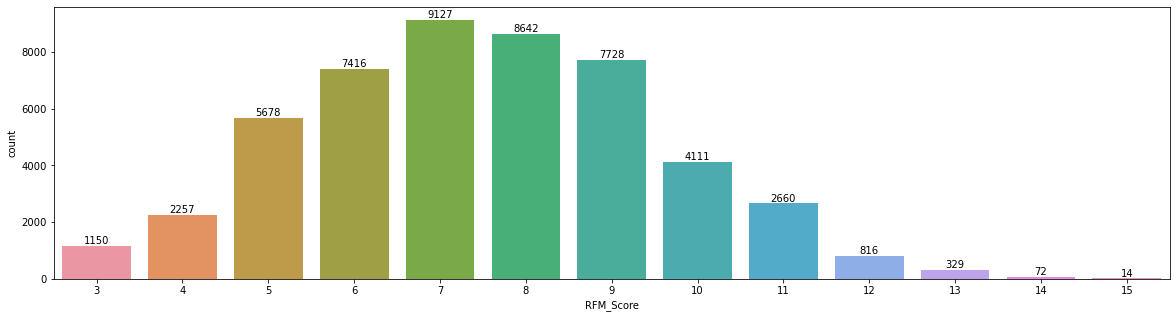

In [11]:
plt.figure(figsize= (20,5))

ax = sns.countplot(x='RFM_Score', data=df)

# Annotate each bar with its count value
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), 
                textcoords='offset points', fontsize=10)

plt.show()

#### As we can see the value counts of the RFM Scores, most customers have rfm scores between the score of 6-9

## RFM Value Segmentation

In [12]:
# Create Segment based on RFM Score
df['Value_Segment'] = pd.qcut(df['RFM_Score'], q= 3, labels= ['Low_Value','Mid_Value','High_Value'])

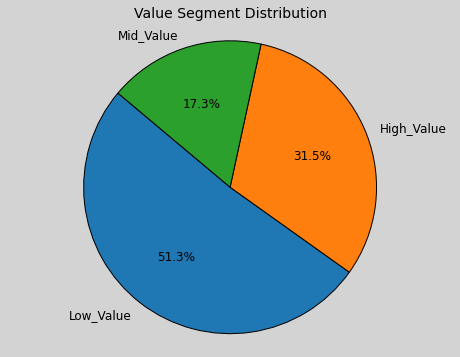

In [13]:
value_counts = df['Value_Segment'].value_counts()

plt.figure(figsize=(8, 6), facecolor= "lightgray")
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'black'},
        textprops={'color': 'black', 'fontsize': 12})
plt.axis('equal')
plt.title('Value Segment Distribution', fontsize = 14)

plt.show()

#### As per value segment distribution we have 51.3% of lowe-value customers, followed by 31.5% of high-value customers and mid-value customers with 17.3% contribution.

## RFM Customer Segmentation

In [14]:
# Creating a new column for RFM Customer Segments

df['RFM_Customer_Segment'] = ''

for i, row in df.iterrows():
    rfm_score = row['RFM_Score']
    
    if rfm_score >= 9:
        df.at[i, 'RFM_Customer_Segment'] = 'Champions'
    elif 6 <= rfm_score < 9:
        df.at[i, 'RFM_Customer_Segment'] = 'Potential Loyalists'
    elif 5 <= rfm_score < 6:
        df.at[i, 'RFM_Customer_Segment'] = 'At Risk Customers'
    elif 4 <= rfm_score < 5:
        df.at[i, 'RFM_Customer_Segment'] = "Can't Lose"
    elif 3 <= rfm_score < 4:
        df.at[i, 'RFM_Customer_Segment'] = "Lost"


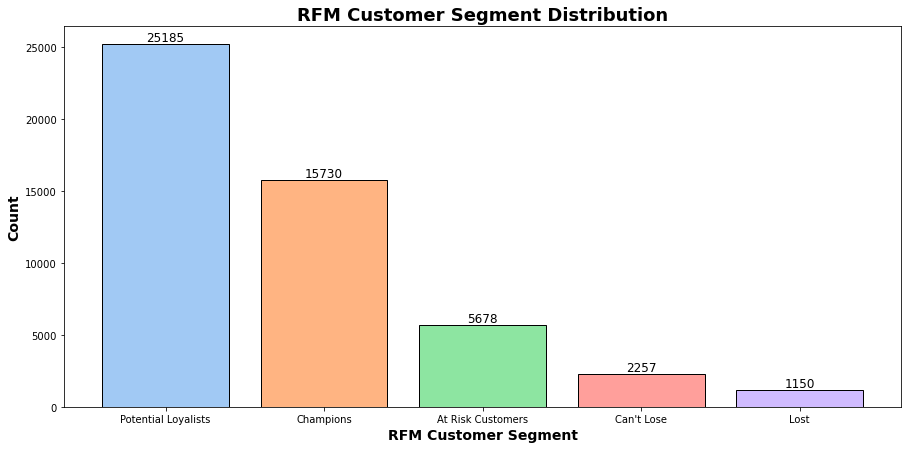

In [15]:
plt.figure(figsize=(15,7))

plt.bar(df['RFM_Customer_Segment'].value_counts().index, df['RFM_Customer_Segment'].value_counts().values, color= sns.color_palette("pastel"), ec= 'black')

for i, count in enumerate(df['RFM_Customer_Segment'].value_counts().values):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=12)

plt.title("RFM Customer Segment Distribution", fontsize=18, fontweight='bold')
plt.xlabel("RFM Customer Segment", fontsize=14, fontweight='bold')
plt.ylabel("Count", fontsize=14, fontweight='bold')
    
plt.show()

#### Customer Segmentation indicates that most of the customers are potential loyalists followed by champions

### Analyzing Customer Segmentation with Value Segmentation

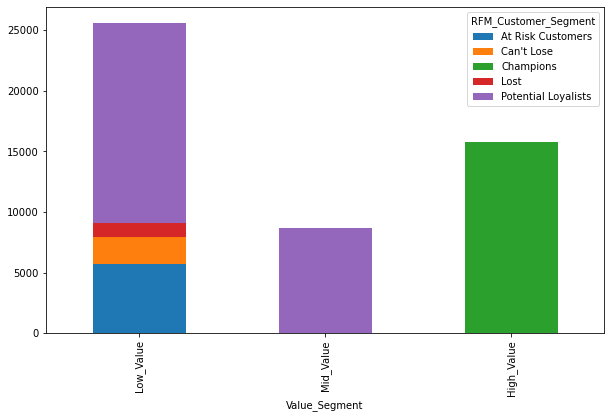

In [16]:
df2 = df[['Value_Segment', 'RFM_Customer_Segment']]
pivot_data = df2.pivot_table(index='Value_Segment', columns='RFM_Customer_Segment', aggfunc=len, fill_value=0)
ax = pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.show()

+ It gives us the information how customer segmentation is divided among the value segmentation
+ We get the info that all the high-value customers are champions with rfm score more than 9
+ All the mid-value customers are potential loyalists having rfm score between 6 and 9
+ Low-value segment is divided between at risk customers, can't lose, lost and maximum number of potential loyalists

### Customer Segmentation with individual RFM Score

In [17]:
df3 = df.groupby(["RFM_Customer_Segment"]).mean()[['Recency_Score', 'Frequency_Score', 'Monetary_Score']].round(2).reset_index()
df3 = df3.melt(id_vars= "RFM_Customer_Segment", var_name= "RFM_variable", value_name= "Mean_Scores")
df3.head()

,RFM_Customer_Segment,RFM_variable,Mean_Scores
0,At Risk Customers,Recency_Score,1.59
1,Can't Lose,Recency_Score,1.50
2,Champions,Recency_Score,4.18
3,Lost,Recency_Score,1.00
4,Potential Loyalists,Recency_Score,2.84


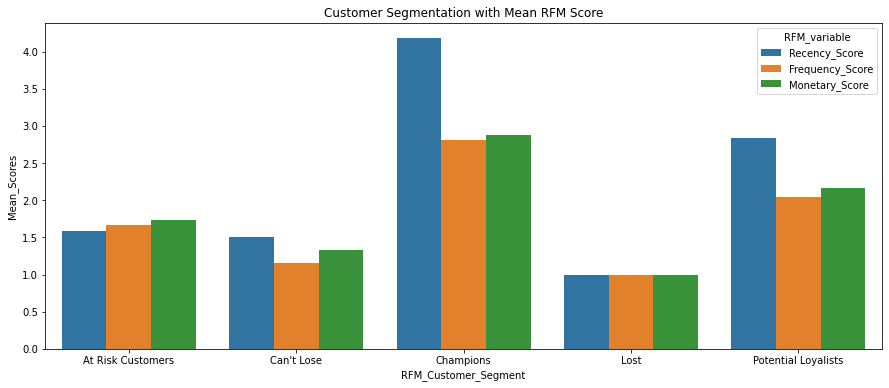

In [18]:
plt.figure(figsize= (15,6))
sns.barplot(x= "RFM_Customer_Segment", y= "Mean_Scores", hue= "RFM_variable", data= df3)
plt.title("Customer Segmentation with Mean RFM Score")
plt.show()

#### Analyzing above chart gives us the idea that mean rfm scores of champions is the highest followed by potential loyalists